In [3]:
from UAVenv import UAVEnv
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import random
import numpy as np
from tqdm import tqdm
import torch
import torch.nn.functional as F
from torch.distributions import Normal
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm

In [4]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_h = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc_h(x))
        return F.softmax(self.fc2(x), dim=1)


class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_h = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc_h(x))
        return self.fc2(x)


In [5]:
class ActorCritic:
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 gamma, device):
        # 策略网络  en: Policy Network
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.critic = ValueNet(state_dim, hidden_dim).to(device)  # 价值网络  en: value network
        # 策略网络优化器  en:Strategic Network Optimizer
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  # 价值网络优化器  en: Value Network Optimizer
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()

    def update(self, transition_dict):
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(
            self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)

        # 时序差分目标 
        # Time difference target
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        td_delta = td_target - self.critic(states)  # 时序差分误差 en: Time difference error
        log_probs = torch.log(self.actor(states).gather(1, actions))
        actor_loss = torch.mean(-log_probs * td_delta.detach())
        # 均方误差损失函数 en: Mean Squared Error Loss Function
        critic_loss = torch.mean(
            F.mse_loss(self.critic(states), td_target.detach()))
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        actor_loss.backward()  # 计算策略网络的梯度 en: Calculate the gradient of the policy network
        critic_loss.backward()  # 计算价值网络的梯度 en: Calculate the gradient of the value network
        self.actor_optimizer.step()  # 更新策略网络的参数 en: Update the parameters of the policy network
        self.critic_optimizer.step()  # 更新价值网络的参数 en: Update the parameters of the value network

In [6]:
def train_on_policy_agent(env, agent, num_episodes):
    return_list = []
    return_list_2=[]
    for i in range(10):
        with tqdm(total=int(num_episodes/10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes/10)):
                episode_return = 0
                transition_dict = {'states': [], 'actions': [], 'next_states': [], 'rewards': [], 'dones': []}
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    transition_dict['states'].append(state)
                    transition_dict['actions'].append(action)
                    transition_dict['next_states'].append(next_state)
                    transition_dict['rewards'].append(reward)
                    transition_dict['dones'].append(done)
                    state = next_state
                    episode_return += reward
                return_list.append(episode_return)
                return_list_2.append(sum(sum(env.uncertainty_matrix))/100)
                agent.update(transition_dict)
                if (i_episode+1) % 10 == 0:
                    pbar.set_postfix({'episode': '%d' % (num_episodes/10 * i + i_episode+1), 'return': '%.3f' % np.mean(return_list[-10:]),'uncertainty_matrix': '%.3f' % np.mean(return_list_2[-10:])})
                pbar.update(1)
    return return_list , return_list_2

In [ ]:
actor_lr = 3e-4
critic_lr = 3e-4
num_episodes = 1000
hidden_dim = 256
gamma = 0.99
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env = UAVEnv()
state_dim = env.state_dim
action_dim = env.action_dim
agent = ActorCritic(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                    gamma, device)

return_list , return_list_2 = train_on_policy_agent(env, agent, num_episodes)

Iteration 9: 100%|██████████| 100/100 [00:15<00:00,  6.34it/s, episode=1000, return=0.212, uncertainty_matrix=0.703]


In [18]:
import pickle

# 保存   
# en: Save
with open("a2c_returns.pkl", "wb") as f:
    pickle.dump((return_list, return_list_2), f)

# 读取
# en: Read
with open("a2c_returns.pkl", "rb") as f:
    return_list, return_list_2 = pickle.load(f)

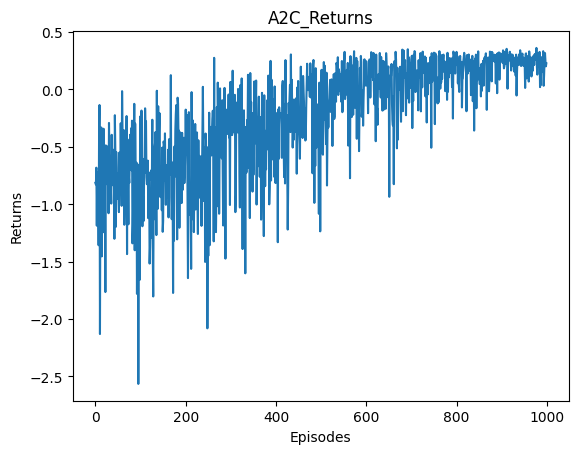

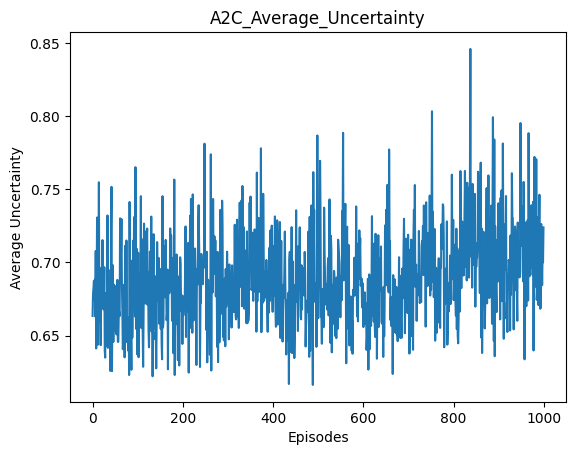

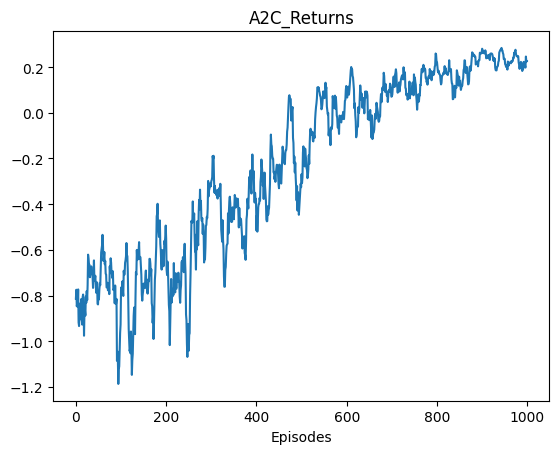

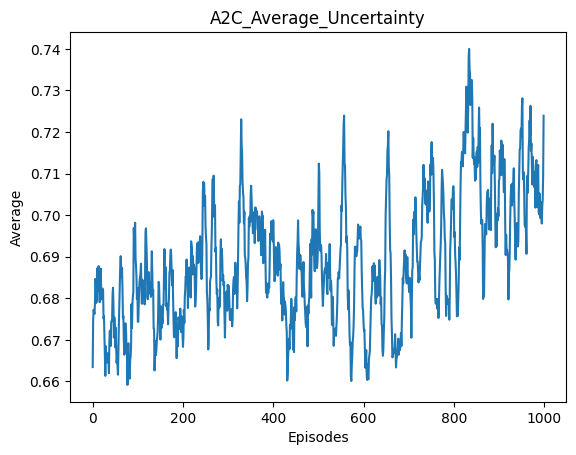

In [19]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('A2C_Returns')
plt.show()
episodes_list = list(range(len(return_list_2)))
plt.plot(episodes_list, return_list_2)
plt.xlabel('Episodes')
plt.ylabel('Average Uncertainty')
plt.title('A2C_Average_Uncertainty')
plt.show()

def moving_average(a, window_size):
    cumulative_sum = np.cumsum(np.insert(a, 0, 0)) 
    middle = (cumulative_sum[window_size:] - cumulative_sum[:-window_size]) / window_size
    r = np.arange(1, window_size-1, 2)
    begin = np.cumsum(a[:window_size-1])[::2] / r
    end = (np.cumsum(a[:-window_size:-1])[::2] / r)[::-1]
    return np.concatenate((begin, middle, end))
mv_return = moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.title('A2C_Returns')
plt.show()
mv_return = moving_average(return_list_2, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Average')
plt.title('A2C_Average_Uncertainty')
plt.show()